Quick analysis

In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl

from pygama import DataGroup
import pygama.io.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf

In [2]:
dg = DataGroup('cage.json', load=True)
run = 56
str_query = f'run=={run} and skip==False'
dg.file_keys.query(str_query, inplace=True)
# view_cols = ['runtype', 'run', 'cycle', 'startTime', 'runtime', 'threshold']
# print(dg.file_keys[view_cols])
print(dg.file_keys)

Loading file key list from: ./fileDB.h5
              unique_key  YYYY  mm  dd  cycle        daq_dir  \
755  cage-cyc757-2020925  2020   9  25    757  /2020/09/Data   
756  cage-cyc758-2020925  2020   9  25    758  /2020/09/Data   
757  cage-cyc759-2020925  2020   9  25    759  /2020/09/Data   
758  cage-cyc760-2020925  2020   9  25    760  /2020/09/Data   
759  cage-cyc761-2020925  2020   9  25    761  /2020/09/Data   
760  cage-cyc762-2020925  2020   9  25    762  /2020/09/Data   
761  cage-cyc763-2020925  2020   9  25    763  /2020/09/Data   
762  cage-cyc764-2020925  2020   9  25    764  /2020/09/Data   
763  cage-cyc765-2020925  2020   9  25    765  /2020/09/Data   
764  cage-cyc766-2020925  2020   9  25    766  /2020/09/Data   
765  cage-cyc767-2020925  2020   9  25    767  /2020/09/Data   
766  cage-cyc768-2020925  2020   9  25    768  /2020/09/Data   
767  cage-cyc769-2020925  2020   9  25    769  /2020/09/Data   
768  cage-cyc770-2020925  2020   9  25    770  /2020/09/Data   


In [3]:
#get runtime, startime, runtype

runtype_list = np.array(dg.file_keys['runtype'])
runtype = runtype_list[0]

rt_min = dg.file_keys['runtime'].sum()
u_start = dg.file_keys.iloc[0]['startTime']
t_start = pd.to_datetime(u_start, unit='s') # str
print(rt_min)

977.8169024928329


In [4]:
# get scan position

if runtype == 'alp':
    alphaDB = pd.read_hdf('alphaDB.h5')
    scan_pos = alphaDB.loc[alphaDB['run']==run]
    radius = np.array(scan_pos['radius'])[0]
    angle = np.array(scan_pos['angle'])[0]
    angle_det = 270 + angle
    print(f'Radius: {radius}; Angle: {angle}')
    
else:
    radius = 'n/a'
    angle = 'n/a'
    angle_det = 'n/a'

In [5]:
lh5_dir = dg.lh5_user_dir #if user else dg.lh5_dir
print(lh5_dir)
hit_list = lh5_dir + dg.file_keys['hit_path'] + '/' + dg.file_keys['hit_file']
print(hit_list)
df_hit = lh5.load_dfs(hit_list, ['trapEmax', 'timestamp', 'bl','bl_sig','A_10','AoE', 'ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/hit')
# df_hit = lh5.load_dfs(alpha_hit_list, ['trapEmax', 'bl','bl_sig','A_10','ts_sec', 'dcr_raw'], 'ORSIS3302DecoderForEnergy/hit')
# print(df_hit)
# print(df_hit.columns)

# dsc = df_hit[['bl','bl_sig','A_10','AoE', 'ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max']].describe()
# dsc = df_hit[['bl','bl_sig','A_10','ts_sec', 'dcr_raw']].describe()
# print(dsc)

/global/homes/g/gothman/projecta/CAGE_lh5_joule/
755    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
756    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
757    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
758    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
759    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
760    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
761    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
762    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
763    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
764    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
765    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
766    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
767    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
768    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
769    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
770    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
771    /global/homes/g/gothman/projecta

In [7]:
print(len(df_hit['timestamp']))
print(len(df_hit['trapEmax']))
ts_array  = np.array(df_hit['ts_sec'])
ts_max = np.amax(ts_array)
df_hit['timestamp'].min

3604559
3604559


<bound method Series.min of 0             4997695
1             6044257
2             6883558
3             7511564
4             7667105
              ...    
3604554    3213610854
3604555    3215492309
3604556    3218930627
3604557    3219008941
3604558    3219800569
Name: timestamp, Length: 3604559, dtype: uint32>

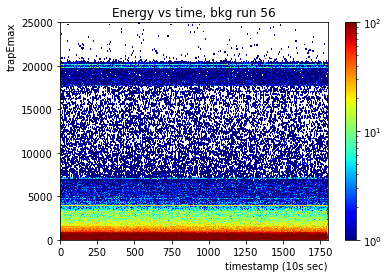

In [14]:
# Baseline vs E

etype = 'trapEmax'

elo, ehi, epb = 0, 25000, 100
tlo, thi, tpb = 0, 1800, 1
# tlo, thi, tpb = 0, 1800, 1
nbx = int((thi-tlo)/tpb)
nby = int((ehi-elo)/epb)

h = plt.hist2d(df_hit['ts_sec'], df_hit['trapEmax'], bins=[nbx,nby],
                       range=[[tlo, thi], [elo, ehi]], cmap='jet', norm=LogNorm(1,100))

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel('timestamp (10s sec)', ha='right', x=1)
plt.ylabel('trapEmax', ha='right', y=1)
plt.title(f'Energy vs time, {runtype} run {run}')
# plt.tight_layout()
plt.show()

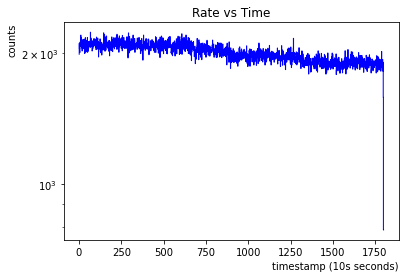

In [15]:
# rate stability
tlo, thi, tpb = 0, 1800, 1
nbx = int((thi-tlo)/tpb)

bl_hist, bins = np.histogram(df_hit['ts_sec'], bins=nbx,
                range=[tlo, thi])

plt.semilogy(bins[1:], bl_hist, ds='steps', c='b', lw=1)

# bl_cut_lo, bl_cut_hi = 8500,10000

# plt.axvline(bl_cut_lo, c='r', lw=1)
# plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('timestamp (10s seconds)', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.title('Rate vs Time')
plt.show()

In [27]:
# use baseline cut and get 1460 events
elo, ehi = 3800, 4500
df_cut = df_hit.query('bl > 8500 and bl < 10000').copy()
e_cut = df_cut.query(f' trapEmax > {elo} and trapEmax < {ehi}').copy()

#create dcr/E 
df_cut['dcr_norm'] = df_cut['dcr_raw'] / df_cut['trapEmax']

#creat new DCR
const = 0.0555
df_cut['dcr_linoff'] = df_cut['dcr_raw'] + const*df_cut['trapEmax']

# #create 10-90
# df_cut['10-90'] = df_cut['tp_90']- df_cut['tp_10']

# #create 50-90
# df_cut['50-90'] = df_cut['tp_90']- df_cut['tp_50']

#create 0-50
df_cut['tp0_50'] = df_cut['tp_50']- df_cut['tp_0']

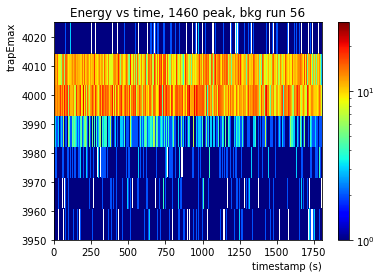

In [29]:
# Baseline vs E

etype = 'trapEmax'

elo, ehi, epb = 3950, 4025, 10
tlo, thi, tpb = 0, 1800, 1
nbx = int((thi-tlo)/tpb)
nby = int((ehi-elo)/epb)

h = plt.hist2d(e_cut['ts_sec'], e_cut['trapEmax'], bins=[nbx,nby],
                       range=[[tlo, thi], [elo, ehi]], cmap='jet', norm=LogNorm())

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel('timestamp (s)', ha='right', x=1)
plt.ylabel('trapEmax', ha='right', y=1)
plt.title(f'Energy vs time, 1460 peak, {runtype} run {run}')
# plt.tight_layout()
plt.show()

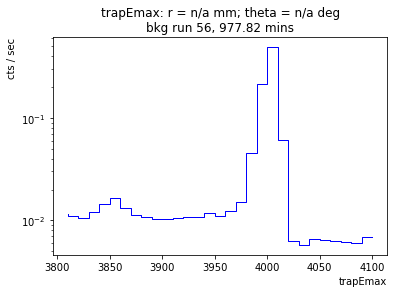

In [25]:
# Make energy spectrum
# elo, ehi, epb = 0, 35000, 10
# elo, ehi, epb = 0, 8000, 10
elo, ehi, epb = 3800, 4100, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)

energy_hist, bins = np.histogram(df_cut['trapEmax'], bins=nbx,
                range=[elo, ehi])
energy_rt = np.divide(energy_hist, rt_min * 60)

plt.semilogy(bins[1:], energy_rt, ds='steps', c='b', lw=1) #, label=f'{etype}'

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / sec', ha='right', y=1)
# plt.legend()
plt.title(f'{etype}: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
plt.show()